# Training

In this notebook we will go through the basic process of training a an automatic mixing model. This will involve combining a dataset with a model and an appropriate training loop. For this demonstration we will [PyTorch Lightning](https://www.pytorchlightning.ai/) to faciliate the training. 

## Dataset
For this demonstration we will use the subset of the [DSD100 dataset](https://sigsep.github.io/datasets/dsd100.html). This is a music source separation data, but we will use it to demonstrate how you can train a model. This is a very small subset of the dataset so it can easily be downloaded and we should not expect that our model will perform very well after training. 

This notebook can be used as a starting point for example by swapping out the dataset for a different dataset such as [ENST-drums](https://perso.telecom-paristech.fr/grichard/ENST-drums/) or [MedleyDB](https://medleydb.weebly.com/) after they have been downloaded. Since they are quite large, we will focus only on this small dataset for demonstration purposes. 

## GPU

This notebook supports training with the GPU. You can achieve this by setting the `Runtime` to `GPU` in Colab using the menu bar at the top.

## Learn More

If you want to train these models on your own server and have much more control beyond this demo we encourage you to take a look at the training recipes we provide in the [automix-toolkit](https://github.com/csteinmetz1/automix-toolkit) repository.

But, let's get started by installing the automix-toolkit.

In [ ]:
!pip install git+https://github.com/csteinmetz1/automix-toolkit

In [2]:
import os
import torch
import pytorch_lightning as pl
import IPython
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display

from argparse import Namespace

%matplotlib inline
%load_ext autoreload
%autoreload 2

from automix.data import DSD100Dataset
from automix.system import System

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First we will download the dataset subset and unzip the archive as well as the pretrained encoder checkpoint.

In [3]:
os.makedirs("checkpoints/", exist_ok=True)
!wget https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/encoder.ckpt
!mv encoder.ckpt checkpoints/encoder.ckpt
    
!wget https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/DSD100subset.zip
!unzip -o DSD100subset.zip 

--2024-08-29 16:42:07--  https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/encoder.ckpt
Resolving huggingface.co (huggingface.co)... 2600:9000:2751:7200:17:b174:6d00:93a1, 2600:9000:2751:9e00:17:b174:6d00:93a1, 2600:9000:2751:cc00:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:2751:7200:17:b174:6d00:93a1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/ec/ee/ecee38df047e3f2db1bd8c31a742f3a08f557470cd67cb487402a9c3ed91b5ea/90c13ab981715e1fc1ae079f15fb6da36d61d6aad29ae5dddd4d3bfd4594546a?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27encoder.ckpt%3B+filename%3D%22encoder.ckpt%22%3B&Expires=1725176505&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNTE3NjUwNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9lYy9lZS9lY2VlMzhkZjA0N2UzZjJkYjFiZDhjMzFhNzQyZjNhMDhmNTU3NDcwY2Q2N2NiNDg3NDAyYTljM2VkOTFiNWVhLzk

# Configuration
Here we select where we want to train on CPU or GPU and what model we will use. 

In [4]:
!nvidia-smi # check for GPU

Thu Aug 29 16:42:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               Off | 00000000:18:00.0 Off |                  Off |
| 30%   31C    P8              16W / 250W |    359MiB / 49140MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
args = {
    "dataset_dir" :  "./DSD100subset",
    "dataset_name" : "DSD100",
    "automix_model" : "dmc",
    "pretrained_encoder" : True,
    "train_length" : 65536,
    "val_length" : 65536,
    "accelerator" : "gpu", # you can select "cpu" or "gpu"
    "devices" : 1, 
    "batch_size" : 4,
    "lr" : 3e-4,
    "max_epochs" : 10, 
    "schedule" : "none",
    "recon_losses" : ["sd"],
    "recon_loss_weights" : [1.0],
    "sample_rate" : 44100,
    "num_workers" : 2,
}
args = Namespace(**args)
    
pl.seed_everything(42, workers=True)

Seed set to 42


42

In [6]:
# setup callbacks
callbacks = [
    #LogAudioCallback(),
    pl.callbacks.LearningRateMonitor(logging_interval="step"),
    pl.callbacks.ModelCheckpoint(
        filename=f"{args.dataset_name}-{args.automix_model}"
        + "_epoch-{epoch}-step-{step}",
        monitor="val/loss_epoch",
        mode="min",
        save_last=True,
        auto_insert_metric_name=False,
    ),
]

# we not will use weights and biases
#wandb_logger = WandbLogger(save_dir=log_dir, project="automix-notebook")

# create PyTorch Lightning trainer
# trainer = pl.Trainer(args, callbacks=callbacks)

trainer = pl.Trainer(
    max_epochs=args.max_epochs,
    accelerator=args.accelerator,
    devices=args.devices,
    callbacks=callbacks,
    # Add other trainer arguments here if needed
)

# create the System
system = System(**vars(args))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/martinez/Documents/anaconda3/envs/dafx24/lib/python3.9/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


Loaded weights from ./checkpoints/encoder.ckpt


# Dataset
Now we will create datasets for train/val/test but we will use the same four songs across all sets here for demonstration purposes.

In [7]:
train_dataset = DSD100Dataset(
    args.dataset_dir,
    args.train_length,
    44100,
    indices=[0, 4],
    num_examples_per_epoch=100,
)
val_dataset = DSD100Dataset(
    args.dataset_dir,
    args.val_length,
    44100,
    indices=[0, 4],
    num_examples_per_epoch=100,
)
test_dataset = DSD100Dataset(
    args.dataset_dir,
    args.train_length,
    44100,
    indices=[0, 4],
    num_examples_per_epoch=100,
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    persistent_workers=True,
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    persistent_workers=False,
)

100%|██████████| 4/4 [00:00<00:00, 3587.94it/s]


Found 4 mixes. Using 4 in this subset.


100%|██████████| 4/4 [00:00<00:00, 3676.80it/s]


Found 4 mixes. Using 4 in this subset.


100%|██████████| 4/4 [00:00<00:00, 3710.95it/s]

Found 4 mixes. Using 4 in this subset.


# Logging
We can launch an instance of TensorBoard within our notebook to monitor the training process. Be patient, it can take ~60 seconds for the window to show.

In [8]:
%load_ext tensorboard
%tensorboard  --logdir="lightning_logs"

Reusing TensorBoard on port 6006 (pid 2428432), started 23 days, 22:22:30 ago. (Use '!kill 2428432' to kill it.)

# Train!
Now we are ready to launch the training process.


In [9]:
trainer.fit(system, train_dataloader, val_dataloader)

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type                        | Params | Mode 
---------------------------------------------------------------------
0 | model        | DifferentiableMixingConsole | 12.4 M | train
1 | recon_losses | ModuleDict                  | 0      | train
2 | sisdr        | SISDRLoss                   | 0      | train
3 | mrstft       | MultiResolutionSTFTLoss     | 0      | train
---------------------------------------------------------------------
12.4 M    Trainable params
0         Non-trainable params
12.4 M    Total params
49.732    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/martinez/Documents/anaconda3/envs/dafx24/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


# Test
After training for a few epochs we will test the system by creating a mix from one of the songs that was in the training set. 

1 bass.wav


1 bass.wav


2 drums.wav


2 drums.wav


3 other.wav


3 other.wav


4 vocals.wav


4 vocals.wav
torch.Size([1, 8, 262144])
torch.Size([1, 1, 262144])


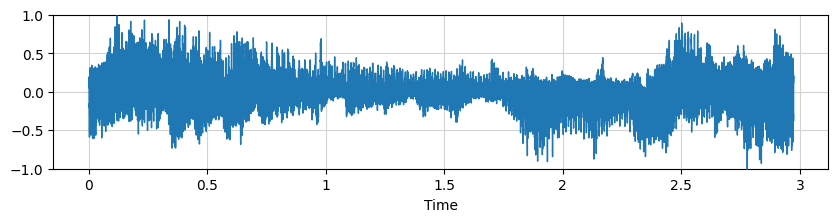

In [10]:
import glob
import torchaudio
start_sample = 262144 * 2
end_sample = 262144 * 3

# load the input tracks
track_dir = "DSD100subset/Sources/Dev/081 - Patrick Talbot - Set Me Free/"
track_ext = "wav"

track_filepaths = glob.glob(os.path.join(track_dir, f"*.{track_ext}"))
track_filepaths = sorted(track_filepaths)
track_names = []
tracks = []
for idx, track_filepath in enumerate(track_filepaths):
    x, sr = torchaudio.load(track_filepath)
    x = x[:, start_sample: end_sample]



    for n in range(x.shape[0]):
      x_sub = x[n:n+1, :]

      gain_dB = np.random.rand() * 12
      gain_dB *= np.random.choice([1.0, -1.0])
      gain_ln = 10 ** (gain_dB/20.0)
      x_sub *= gain_ln 

      tracks.append(x_sub)
      track_names.append(os.path.basename(track_filepath))
      IPython.display.display(ipd.Audio(x[n, :].view(1,-1).numpy(), rate=sr, normalize=True))    
      print(idx+1, os.path.basename(track_filepath))

# add dummy tracks of silence if needed
if system.hparams.automix_model == "mixwaveunet" and len(tracks) < 8:
    tracks.append(torch.zeros(x.shape))

# stack tracks into a tensor
tracks = torch.stack(tracks, dim=0)
tracks = tracks.permute(1, 0, 2)
# tracks have shape (1, num_tracks, seq_len)
print(tracks.shape)

# listen to the input (mono) before mixing
input_mix = tracks.sum(dim=1, keepdim=True)
input_mix /= input_mix.abs().max()
print(input_mix.shape)
plt.figure(figsize=(10, 2))
librosa.display.waveshow(input_mix.view(2,-1).numpy(), sr=sr, zorder=3)
plt.ylim([-1,1])
plt.grid(c="lightgray")
plt.show()
IPython.display.display(ipd.Audio(input_mix.view(1,-1).numpy(), rate=sr, normalize=False))

Above we can hear the tracks with a simple mono mix. Now we will create a mix with the model we just trained.

torch.Size([1, 2, 262144])


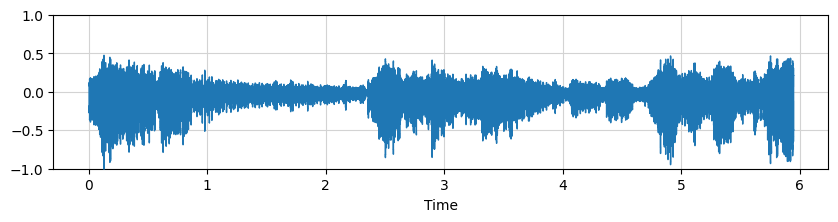

bass.wav tensor([-8.9969,  0.5640])
bass.wav tensor([-4.5226,  0.6432])
drums.wav tensor([-6.7178,  0.5868])
drums.wav tensor([-5.4589,  0.6139])
other.wav tensor([-0.3160,  0.6668])
other.wav tensor([6.6966, 0.7568])
vocals.wav tensor([6.4484, 0.7839])
vocals.wav tensor([-2.8909,  0.6442])


In [11]:
tracks = tracks.view(1,8,-1)

with torch.no_grad():
  y_hat, p = system(tracks)
  
# view the mix
print(y_hat.shape)
y_hat /= y_hat.abs().max()
plt.figure(figsize=(10, 2))
librosa.display.waveshow(y_hat.view(2,-1).cpu().numpy(), sr=sr, zorder=3)
plt.ylim([-1,1])
plt.grid(c="lightgray")
plt.show()
IPython.display.display(ipd.Audio(y_hat.view(2,-1).cpu().numpy(), rate=sr, normalize=True))

# print the parameters
if system.hparams.automix_model == "dmc":
    for track_fp, param in zip(track_names, p.squeeze()):
        print(os.path.basename(track_fp), param)

You should be able to hear that the levels have been adjusted and the sources panned to sound more like the original mix indicating that our system learned to overfit the songs in our very small training set. 